# Agent Self-Regulation

Listening to [Flume - Sintra ](https://www.youtube.com/watch?v=fpyDJWxCep8) got me thinking of computational approaches to recreate organic drum patterns characterized by [syncopation](https://en.wikipedia.org/wiki/Syncopation). 

My first approach was to conceive the composition as a self-regulating agent whose actions produce sounds. Each action has specific effects on user-defined properties. I thought that by assigning semantically motivated effects to each action and by giving the agent a property baseline to follow, I could recreate the desired patterns.

Sections:

-   Setups and imports
-   Function fefinitions
-   Compute audio features
-   Initialize and run the simulation
-   Export MIDI-Files

## Setup and Imports


In [ ]:
#@title Setup
print('Installing dependencies...')
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi

!pip install -qU magenta
!pip install tqdm
#prevent Error: from matplotlib import _png ImportError: cannot import name '_png' from 'matplotlib'
!pip install matplotlib==3.1.1

!pip install scipy==1.7.3
# Hack to allow python to pick up the newly-installed fluidsynth lib. 
# This is only needed for the hosted Colab environment.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library

print('Importing libraries and defining some helper functions...')
from google.colab import files

import magenta
import note_seq
import tensorflow

print('🎉 Done!')
print(magenta.__version__)
print(tensorflow.__version__)

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm

In [ ]:
!git clone https://github.com/a-sumo/hyperstep

## Define core functions

The function **_signal** defines a goal signal that will guide the agent's actions and thus guide the composition. 

The function **tempo_effect** will accumulate a quantity following each use of an action. It can be thought of as an un-normalized indicator of an action's frequency.
I designed this function in an attempt to down-regulate the use repeated use of actions with small effects within a short timeframe and thus encourage variety in action selection.

The function **run** implements the simulation.
At each step, it takes into account the combined effects of the actions that were taken in the previous step, coupled with the goal value of the current step in order to decide which action to take next. 
The decision is based on threshold value. I've chosen against assigning probabilities to each action because that didn't seem to fit the framework. 

*Note*: One could state that the probability of breathing out increases as the concentration of carbon dioxide increases in our blood. But that would be inaccurate because we know that in a healthy body, the detection of changes in levels of CO2 and O2 in our blood triggers the expansion/contraction of our diaphram with causes us to breathe in a,dout. Unless we account for random failure in each of these steps, this looks to me like a fairly deterministic process. 
This example may seem anecdotal, but the temporal organization of drums may very well stem from something as simple as the temporal organization of self-regulating processes in our body such as breathing. After all, for something to resonate so deeply and universally with humans, it must stem from processes experienced by all humans. We may not need to look further than the inside of our bodies.

In [7]:
def _signal(duration=1, sr=20500, type='constant', amplitude=1, frequency=0.1, offset=0):
    """
    Utility signals.
    duration: duration of the signal in seconds,
    sr: sampling rate,
    type: signal type ('constant', 'ramp', 'sine', 'sawtooth', 'triangle', 'square')
    amplitude: signal amplitude
    frequency: signal frequency for 'sine', 'sawtooth', 'triangle', 'square'
    offset: signal offset(in value)

    """
    x = np.arange(duration*sr)/sr
    if type=='constant':
        y = offset * np.ones(duration*sr) 
    elif type == 'ramp':
        y = amplitude * x
    elif type=='sine':
        y = offset + amplitude * np.sin(2 * np.pi * frequency * x)
    elif type == 'sawtooth':
        y = offset + amplitude * signal.sawtooth(2 * np.pi * frequency * x)
    elif type == 'triangle':
        y = offset + amplitude * np.abs(signal.sawtooth(2 * np.pi * frequency * x))   
    elif type == 'square':
        y = offset + amplitude * signal.square(2 * np.pi * frequency * x)  
    return y 
    
def tempo_effect(action_history, sr):
    """
    For all timesteps in history, add the timestep length (inverse of sampling rate) each time an action is taken.

    action_history: array of actions
    sr: sampling rate

    """
    # Start from a base value of 1. This is an arbitrary choice.
    # By keeping it within the function, we reduce the number of parameters to set manually.
    state = 1
    for k in range (action_history.shape[0]):
        if action_history[k] == 1:
            state += 1/sr
        else:
            state -= 1/sr
    return state

def run(mode='tempo',
        initial_state=0,
        episode_duration=10,
        action_rate=1,
        goal_value=None,
        goal_range=0.1,
        tension_vals=None,
        tension_multiplier=None,
        tempo_action=0,
        sr_global=20):
    """
    Run the simulation.
    
    tension_multiplier: multiplying factor for the tension_integral
    tempo_action: action over which to accumulate the tempo effect. This action will
    """
    num_actions = len(tension_vals)
    num_steps = episode_duration*sr_global
    action_history = np.zeros((num_actions,num_steps))
    state_history = np.zeros(num_steps)
    #accumulate the values of tension effect over 
    tension_integral = np.array([np.trapz(tension_vals[i])  for i in range(num_actions)])
    tension_integral = np.multiply(tension_integral,tension_multiplier)
    #agent state
    state = initial_state 
    #timesteps at which an action is triggered
    trigger_timesteps = []
    for i in range(num_actions):
        trigger_timesteps.append([])
    tension_increment = effect_increment_scale/sr_global
    tension_vals =  [tension_increment * tension_vals[i] * tension_multiplier[i] for i in range(len(tension_vals))] 
    for k in tqdm(range(num_steps)): 
        if mode == 'tempo':
            # accumulate a small value (whose dimension is that of time)
            # for all occurrences of 'tempo_action' in history
            state = tempo_effect(action_history[tempo_action], sr_global)
            #
            state_history[k] = state
            if k % (1 / action_rate) == 0:

                #if "tempo" is greater than the goal value, do not act (down-regulation)
                if state > goal_value[k]:
                    action = 0

                #if "tempo" is lower than the goal value, act
                elif state < goal_value[k]:
                    
                    action = tempo_action
                action_history[action,k]=1

                trigger_timesteps[action].append(k)
                
        elif mode == 'tension': 
            V = tension_integral
            if k == 0 or k % (1/action_rate)==0:       
                # if the state is greater than the goal value + the goal range       
                if state > goal_value[k] + goal_range:
                    # pick the action with lowest effect 
                    action = np.argmin(V)
                    # add current timestep to action history
                    action_history[action,k] = 1
                    # add current timestep to action trigger history
                    trigger_timesteps[action].append(k)
                #else, if the state is lower than the goal value - the goal range
                elif state < goal_value[k] - goal_range:
                    #pick the action with highest effect 
                    action = np.argmax(V)
                    # add current timestep to action history
                    action_history[action,k] = 1
                    # add current timestep to action trigger history
                    trigger_timesteps[action].append(k) 

            # The following section is currently unnecessarily sophisticated considering
            # how little semantically relevant information has been extracted from audio.
            # There are definitely more efficient approaches in the utility system literature
            # https://en.wikipedia.org/wiki/Utility_system

            # add the effects (tension_vals) of all actions active at the current timestep
            # do so by sampling their tension values array(tension_vals) at the timestep relative(offset) to 
            # start of the action (trigger_timestep)
            for a in range(num_actions):
                for i in range(len(trigger_timesteps[a])):
                    # if the current action was triggered at least once
                    if(len(trigger_timesteps[a])>0):
                        # timestep at which the current action was triggered
                        min = trigger_timesteps[a][i]
                        # timestep at which the current action ended
                        max = trigger_timesteps[a][i] + len(tension_vals[a])

                        #sample the values of tensions for 
                        sampling_range = np.arange(min,max)
                        #time offset of the current action 
                        offset = trigger_timesteps[a][i]
                    #if the current action was never triggered
                    else:
                        sampling_range = range(0)
                        offset = 0
                        #the state history keeps the value from the previous iteration
                        state = state_history[k-1] 
                        #save the current state in state history
                        state_history[k] = state
                    #if the current timestep is within the time range in which the action is active 
                    if k in sampling_range:
                        #sample tension values and add to the current state
                        k2 = librosa.frames_to_samples
                        #sample and add the value of the tension_array at the timestep
                        # k - offset 
                        state += tension_vals[a][k-offset]
                        #save the current state in state history
                        state_history[k] = state
                    else:
                        #empty the trigger "history" of the current action
                        for m in range(k):
                            if m in trigger_timesteps[a]:
                                trigger_timesteps[a].remove(m)
        #Reset state
        # state = 0
    return (action_history,state_history)

def viz_episode(mode='tempo',
                action_history=None,
                state_history=None,
                goal_value=None,
                sr_global=20,
                episode_duration=10,
                goal_range=0.1,):

    x=np.arange(episode_duration*sr_global)/sr_global
    fig1, ax1 = plt.subplots(action_history.shape[0])
    fig2,ax2 = plt.subplots(1)
    ax2.plot(x,np.ones_like(x)*goal_value,label="goal_value")
    
    for i in range(action_history.shape[0]):
        ax1[i].scatter(x,action_history[i],label='action history: '+ str(i))
        ax1[i].set_title("Action Activations ")
        ax1[i].legend(loc='lower left')
    if mode == 'tension':
        ax2.plot(x,goal_value+goal_range,label="goal_max")
        ax2.plot(x,goal_value-goal_range,label="goal_min")
    ax2.plot(x,state_history,label="state history")
    ax2.set_title("State History")
    ax2.legend(loc='lower left')
    fig2.set_figheight(7)
    fig2.set_figwidth(7)
    return 


## Compute audio features

This section is fairly tentative but I wanted to keep it in the notebook to show how subtly difficult it is to:

-   extract semantically meaningful features from raw audio samples
-   determine the effect of each action/sound based on those features

This was not successful, mainly because the agent's decision-making algorithm is too coarse compared to the resolution at which the differences between audio samples and their effects become significant. 


Intuitively, kicks should convey a notion of impulse, positive energy being injected into a system. Snares on the other hand should be 'dual' to kicks and convey a release of energy.

It would be interesting, though very challenging, to recover these semantic associations from data alone.

In [4]:
!ls

hyperstep  sample_data


tension_integral muffled_kick: 2118.4829126564923
tension_integral snare_FPC: 942.3963585149115


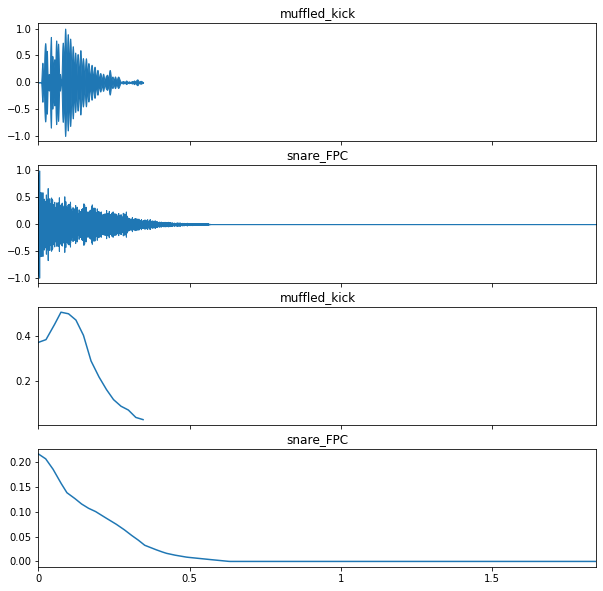

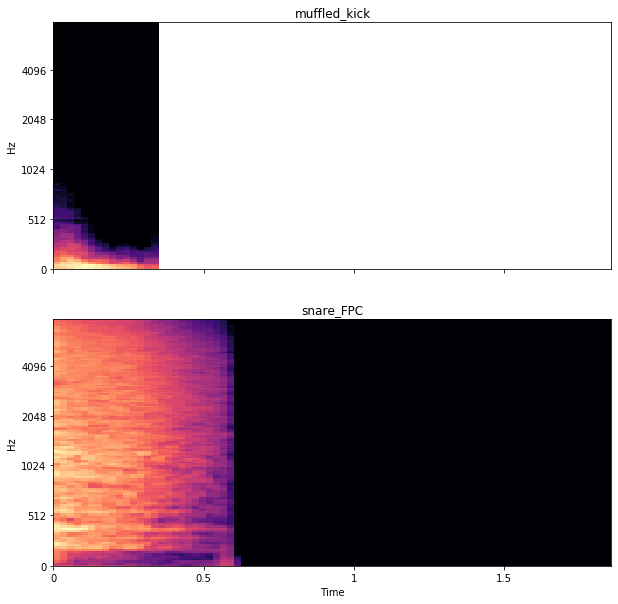

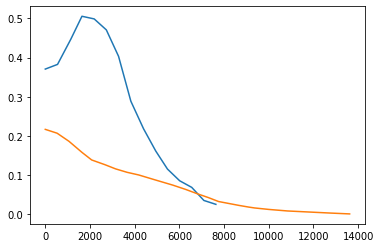

In [5]:
import librosa, librosa.display
import IPython.display as ipd
from IPython.display import Audio
from scipy.signal import hilbert,resample
from scipy import interpolate
y_kick_802_2,sr = librosa.load('/content/hyperstep/audio/drum_samples/kick_802_2.wav')
snare_FPC,_ = librosa.load('/content/hyperstep/audio/drum_samples/snare_FPC.wav')
y_tom_16_inch_4,_ = librosa.load('/content/hyperstep/audio/drum_samples/tom_16_inch_tom_4.wav')
y_tom_909,_ = librosa.load('/content/hyperstep/audio/drum_samples/tom_909.wav')
muffled_kick,sr = librosa.load('/content/hyperstep/audio/drum_samples/muffled_kick.wav')
brake_sound,sr = librosa.load('/content/hyperstep/audio/drum_samples/422442__vacuumfan7072__jbrake-sim-96k.wav')
y_tom_909_envelope = hilbert(y_tom_909)


# y_kick_808, sr = librosa.load(kick_808_2)
# y_snare_lin, sr = librosa.load(snare_linn)
# y_tom_909, sr = librosa.load(tom_909)
# drum_samples = [muffled_kick,brake_sound,y_tom_16_inch_4,y_tom_909]
# drum_names = ['muffled_kick','brake_snare','y_tom_16_inch_4','tom_909']
drum_samples = [muffled_kick,snare_FPC]
drum_names = ['muffled_kick','snare_FPC']
rms = [None] * len(drum_samples)
effect_duration = [None] * len(drum_samples)
show_figs = True
if show_figs:
    fig, ax = plt.subplots(nrows=len(drum_samples)*2,sharex=True)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    fig2, ax2 = plt.subplots(nrows=len(drum_samples),sharex=True)
    fig2.set_figheight(10)
    fig2.set_figwidth(10)
    fig3,ax3 = plt.subplots(nrows=1,sharex=True)
for i in range(len(drum_samples)):
    #set all max audio intensities to 1
    if np.max(np.abs(drum_samples[i]))>0:
        drum_samples[i] *= 1/np.max(drum_samples[i])
    S = librosa.feature.melspectrogram(y=drum_samples[i], sr=sr, n_mels=128,
                                    fmax=8000)
    rms[i] = librosa.feature.rms(y=drum_samples[i]).squeeze()
    times_audio = librosa.samples_to_time(np.arange(drum_samples[i].shape[0]),sr=sr)
    new_length = times_audio.size
    y_rms = rms[i]
    x_rms = np.arange(y_rms.size)
    new_x_rms = np.linspace(x_rms.min(),x_rms.max(), new_length)
    rms[i] = interpolate.interp1d(x_rms, y_rms, kind='linear')(new_x_rms)
    effect_duration[i] = librosa.samples_to_time(np.arange(rms[i].shape[0]),sr=sr)[-1]
    S_dB = librosa.power_to_db(S, ref=np.max)
    #plot
    if show_figs:
        librosa.display.waveplot(drum_samples[i], sr=sr, ax=ax[i])
        ax[i+2].plot(times_audio, rms[i], label='RMS Energy')
        ax[i].set(title=drum_names[i])
        ax[i].label_outer()
        ax[i+2].set(title=drum_names[i])
        ax[i+2].label_outer()
        img = librosa.display.specshow(S_dB, x_axis='time',

                            y_axis='mel', sr=sr,

                            fmax=8000, ax=ax2[i])
        ax2[i].set(title=drum_names[i])
        ax2[i].label_outer()
#Compute Audio Features 
rms_effect = []
rms_integral = []
lower_threshold = 0.001
num_action_effects = len(rms)
for i in range(num_action_effects):
    rms_ = rms[i].copy()
    rms_[np.where(rms_<lower_threshold)] = 0
    rms_ = np.trim_zeros(rms_)
    rms_effect.append(rms_)
    rms_integral.append(np.trapz(rms_))
    print('tension_integral '+drum_names[i]+':',np.trapz(rms_))
    ax3.plot(np.arange(rms_effect[i].size),rms_effect[i])

## Initialize and run the simulation

In the  following cells, we initialize and run the simulation.

Unfortunately, the initialization is still extremely  unintuitive. The parameters, although physically motivated are opaque in their current form.
The interface can be made more interactive by allowing the user to manually set a goal function instead of using pre-defined signals. This can be implemented by embeddnig Javascript code inside the notebook.
The parameter choice can be made more even intuitive by implementing real-time interaction between the agent and the user, but that may be outside of the scope of Jupyter Notebooks.

In [44]:
#Simulation mode. I thought of combining both tempo and tension effects but was unsuccessful.
mode = 'tension'
#global sampling rate(s-1) 
sr_global = sr  
#effect curve sampling rate(s-1) 
# the action_rate parameter determines how often the agent acts, it indirectly sets the rhythm of your drum pattern
action_rate = 0.0002 
#episode duration(s)
episode_duration = 10
#estimation window (s) (currently unused)
estimation_window = 1 
# global multiyplying factor for the magnitude of the effects of each action
effect_increment_scale = 10  

# The Goal Value is the most important setting 
#goal_value = _signal(duration=episode_duration,sr=sr_global,type='triangle',amplitude=2,offset=2,frequency=0.2) * _signal(duration=episode_duration,sr=sr_global,type='square',amplitude=1,offset=2,frequency=0.2)
goal_value = _signal(duration=episode_duration,sr=sr_global,type='constant',amplitude=0,offset=2) * _signal(duration=episode_duration,sr=sr_global,type='square',amplitude=1,offset=2,frequency=0.5)


goal_range = 1
tension_multiplier = np.ones(len(rms_effect))
#In this example, we associate:
# kicks and toms with contraction 
# snares and claps with relaxation.
for i in range(len(drum_names)):
    # here, snares and claps have stronger and opposite effect to kicks and toms
    drum_name = drum_names[i]
    if drum_name[i].find('kick') !=-1 or drum_name.find('tom') !=-1:
        tension_multiplier[i] = 1
    elif drum_name.find('snare') != -1 or drum_name.find('clap') != -1:
        tension_multiplier[i] = -1

tension_multiplier *= effect_increment_scale

action_history, state_history = run(
        mode=mode,
        initial_state=1,
        episode_duration=episode_duration,
        action_rate=action_rate,
        goal_value=goal_value,
        goal_range=goal_range,
        tension_vals=rms_effect,
        tension_multiplier=tension_multiplier,
        tempo_action=0,
        sr_global=sr_global)


100%|██████████| 220500/220500 [00:06<00:00, 36245.26it/s]


## Visualize the Episode

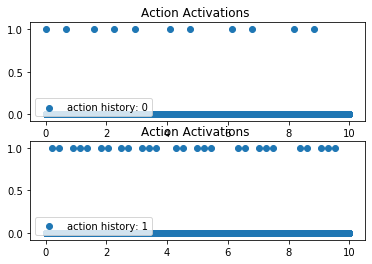

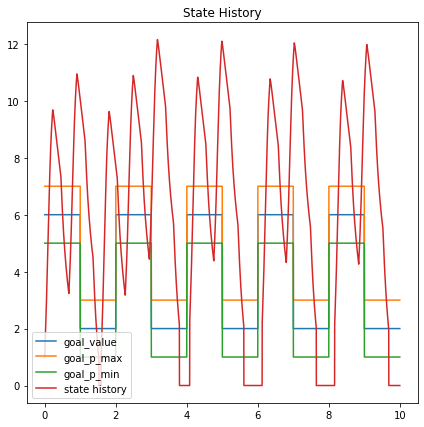

In [45]:
viz_episode(
    mode=mode,
    action_history=action_history,
    state_history=state_history,
    goal_value=goal_value,
    sr_global=sr_global,
    episode_duration=episode_duration,
    goal_range=goal_range
    )

## Export MIDI files

Because PyFluidSynth requires a Soundfont, and the initial samples are audio-files we can't use these samples for the synthesis of the final sounds.
Nonetheless, the available soundfonts are sufficient to getan idea of the overall melody.

For a tutorial see [hello mangenta](https://colab.research.google.com/drive/1_6Is2gcnpAWuWQ6g-vf9LRSlnOLB2V8j#scrollTo=PfRDVhNs3UFx) notebook

In [47]:
from note_seq.protobuf import music_pb2
import note_seq
drums = music_pb2.NoteSequence()
# Add the notes to the sequence.
#from https://github.com/magenta/note-seq/blob/a715b102e84f36057474fe1be8f4e3c2af4cb7c3/note_seq/testing_lib.py#L33
DEFAULT_DRUM_TYPE_PITCHES = [
    # kick drum
    [36, 35],

    # snare drum
    [38, 27, 28, 31, 32, 33, 34, 37, 39, 40, 56, 65, 66, 75, 85],

    # closed hi-hat
    [42, 44, 54, 68, 69, 70, 71, 73, 78, 80, 22],

    # open hi-hat
    [46, 67, 72, 74, 79, 81, 26],

    # low tom
    [45, 29, 41, 43, 61, 64, 84],

    # mid tom
    [48, 47, 60, 63, 77, 86, 87],

    # high tom
    [50, 30, 62, 76, 83],

    # crash cymbal
    [49, 52, 55, 57, 58],

    # ride cymbal
    [51, 53, 59, 82]
]
mode = "drums"
save_drums = True
new_y = np.array(action_history[0]*1 + action_history[1]*2,dtype='int32')
note_times = np.array([1/sr_global,effect_duration[0],effect_duration[1]])
sequence = music_pb2.NoteSequence()
drums = music_pb2.NoteSequence()
current_time = 0
if mode == "note":
    action_pitches = [0,40,60]
    action_velocities = [0,20,20]
    for i in range(len(new_y)):
        if new_y[i]>0:
            sequence.notes.add(pitch=action_pitches[new_y[i]], start_time=current_time, end_time= current_time + note_times[new_y[i]], velocity=20)
        current_time += 1/sr_global
elif mode == "drums":
    action_pitches = [0,DEFAULT_DRUM_TYPE_PITCHES[0][1] ,DEFAULT_DRUM_TYPE_PITCHES[2][7]]
    action_velocities = [0,20,20]
    for i in range(len(new_y)):
        if new_y[i]>0:
            sequence.notes.add(pitch=action_pitches[new_y[i]], start_time=current_time, end_time= current_time + note_times[new_y[i]],is_drum=True, instrument=new_y[i], velocity=20)
            if save_drums:
                drums.notes.add(pitch=60, start_time=current_time, end_time= current_time + note_times[new_y[i]],is_drum=True, instrument=new_y[i], velocity=20)
        current_time += 1/sr_global   

# for i in range(len(new_y)):
#     drums[new_y[i]].notes.add(pitch=60, start_time=current_time, end_time= current_time + note_time, is_drum=True, instrument=10, velocity=20)
#     current_time += note_time 
    
if save_drums:
    drums.tempos.add(qpm=60)
    midi_filename = 'drums_sequence_output.mid'
    note_seq.sequence_proto_to_midi_file(drums, midi_filename)
    files.download(midi_filename)
# This is a colab utility method that visualizes a NoteSequence.
note_seq.plot_sequence(sequence)

# This is a colab utility method that plays a NoteSequence.
note_seq.play_sequence(sequence,synth=note_seq.fluidsynth)
# note_seq.sequence_proto_to_midi_file(sequence, mode + '_sample_output.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Self-regulation itself is insufficient to capture the richness of syncopatic drum patterns. A more appropriate framework is that of locomotion.
What mainly determines the temporal structure of the drums is the agent's goal value. 

So far, this has been defined abstractly and built by composing various signals. However, these signals haven't been motivated nor explained. 
In living organisms, self-regulation is a by-product of activity. Here we have defined no activity. For the sake of intuitiveness for user interaction we can choose animal locomotion. 
Particularly, we'll focus on animal locomotion at *spatio-temporal scales naturally perceptible and analyzable by humans*.  

This is very important as it orients our development towards *relatable* musical patterns.

Example

Bipedal locomotion: a snare is to a kick what a step with the left leg is be to one with the right leg. The two actions are necessary to keep the agent in balance(self-regulation), but the goal itself is to move towards a certain location(locomotion). 



